# Speed analysis
- Analysis how the DA and ACh response are modulated by speed

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
import itertools
import os
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions, get_session_path

In [2]:
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'

In [16]:
ACh_sessions = pd.read_pickle('../ACh_DA_group_analysis/ACh_sessions.pkl')
ACh_sessions['path'] = ACh_sessions.apply(get_session_path,axis=1, args=(session_path,))
ACh_sessions = ACh_sessions[ACh_sessions.animal_id=='TT001']

In [17]:
ds_combined_ACh = load_and_concat_dataset(ACh_sessions.path, load_behaviour_dataset=True)


  0%|          | 0/4 [00:00<?, ?it/s]

Concating datasets...


,session_id,event_time,last_bar_off_zscored_df_over_f,first_reach_travel_time,trial_outcome
time_range,,,,,
0,56,56,56,56,56
1,52,52,52,52,52
2,56,56,56,56,56
3,51,51,51,51,51


,session_id,event_time,first_spout_zscored_df_over_f,first_reach_travel_time,trial_outcome
time_range,,,,,
0,56,56,56,56,56
1,52,52,52,52,52
2,56,56,56,56,56
3,51,51,51,51,51


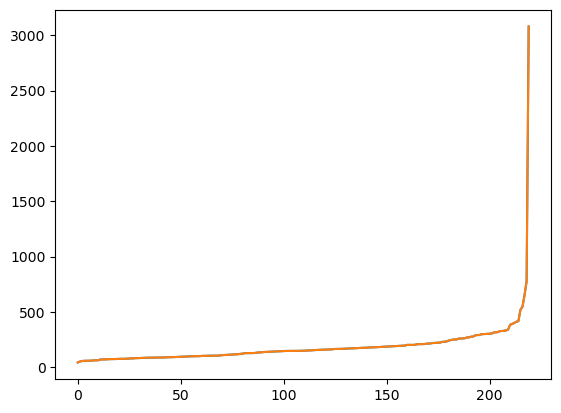

In [36]:
def analyze_speed(xr_combined, var_name):
    df2plot = xr_combined[[var_name, 'first_reach_travel_time', 'trial_outcome']].to_dataframe().reset_index()
    df2plot = df2plot.dropna()
    df = df2plot.groupby('trial_nb').first()
    
    #remove outliner
    thres = np.percentile(df.first_reach_travel_time,90)
    plt.plot(sorted(df.first_reach_travel_time))
    df[df.first_reach_travel_time>500] = None
    
    # df['time_range'] = pd.cut(df.first_reach_travel_time, 2)
    df['time_range'] = pd.qcut(df.first_reach_travel_time, 4, labels=range(4))
    
    display(df.groupby('time_range').count())
    
    df2plot = df2plot.merge(df.time_range, on='trial_nb')
    df2plot = df2plot.rename(columns={var_name: 'zscored_df_over_f'})
    df2plot['event'] = var_name.replace('_zscored_df_over_f','')
    
    return df2plot

var_names = ['last_bar_off_zscored_df_over_f',
            # 'hold_for_water_zscored_df_over_f',
            # 'first_bar_off_zscored_df_over_f',
            'first_spout_zscored_df_over_f']

df2plot = []

for v in var_names:
    df = analyze_speed(ds_combined_ACh, v)
    df2plot.append(df)
    
df2plot = pd.concat(df2plot)
df2plot['animal_id'] = df2plot.session_id.apply(lambda x: x.split('-')[0])
df2plot = df2plot[df2plot.trial_outcome=='success']

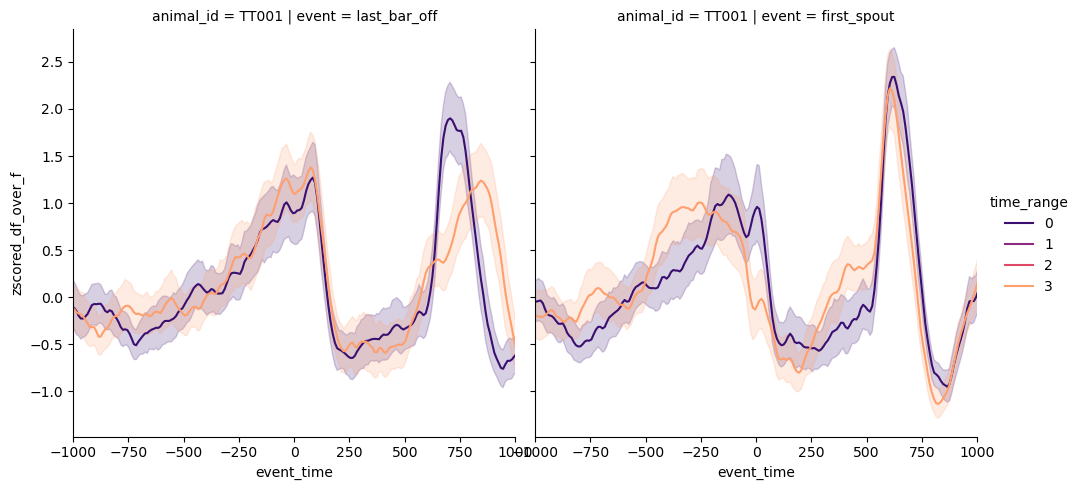

In [39]:
df2plot = df2plot[df2plot.time_range.isin([0,3])]
g = sns.relplot(df2plot, x='event_time',
                y='zscored_df_over_f', 
                row='animal_id',
                col = 'event',
                kind='line',
                errorbar='ci',
                # errorbar=None,
                hue='time_range', palette='magma')

g.set(xlim=[-1000,1000])